# 소프트맥스 회귀
## 다항분류(다중 클래스 분류)의 이해
### 1) 다항 분류
- 이진 분류: 두 개의 선택지 중 하나를 고르는 문제
- 다항 분류: 세 개 이상의 선택지 중 하나를 고르는 문제
### 2) 소프트맥스 함수
- 다항 분류 활성화 함수
- 뉴런의 출력값에 대하여 class 분류를 위하여 마지막 단계에서 출력값에 대한 정규화를 해주는 함수.
- 결과물의 수치의 합은 언제나 1.0이다.
- 소프트맥스 함수의 출력값은 확률로 해석할 수 있다.

사진속 인물이 지금 슬픈 표정인지, 웃는 표정인지, 화난 표정인지 확률적으로 수치화한다고 했을때, 슬픔 (11%), 웃음 (29%), 화남(60%) 과같이 확률적 분류를 할 때 용이

## #01. 패키지 준비 

In [18]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential      # 순서층을 구성하는 모델 객체 생성 기능
from tensorflow.keras.layers import Dense           # 모델 객체에 학습을 위한 층을 쌓는다.
from tensorflow.keras.optimizers import RMSprop,SGD # 옵티마이저
from tensorflow.keras.losses import mse             # 활성화 함수
import pandas as pd 
import sys
import os
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

# 학습에 대한 콜백함수 참조
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical


## #02. 데이터 준비


In [5]:
origin = pd.read_excel("https://data.hossam.kr/F03/iris.xlsx")
origin.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## #03. 데이터 전처리

### 결측치 확인

In [6]:
origin.isnull().sum()

Sepal.Length    0
Sepal.Width     0
Petal.Length    0
Petal.Width     0
Species         0
dtype: int64

### 종속변수 라벨링을 위해 값의 종류 확인

In [7]:
uni = origin['Species'].unique()
print(uni)

['setosa' 'versicolor' 'virginica']


### 종속변수 라벨링

In [8]:
origin['Species'] = origin['Species'].astype('category').cat.rename_categories({'setosa': 0, 'virginica': 1, 'versicolor': 2})
origin['Species'].value_counts()

Species
0    50
2    50
1    50
Name: count, dtype: int64

## #04. 탐색적 데이터 분석
### 기본통계 확인

In [9]:
origin.describe()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


### 산점도 행렬 확인

c:\Users\Hamin\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Hamin\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Hamin\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Hamin\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

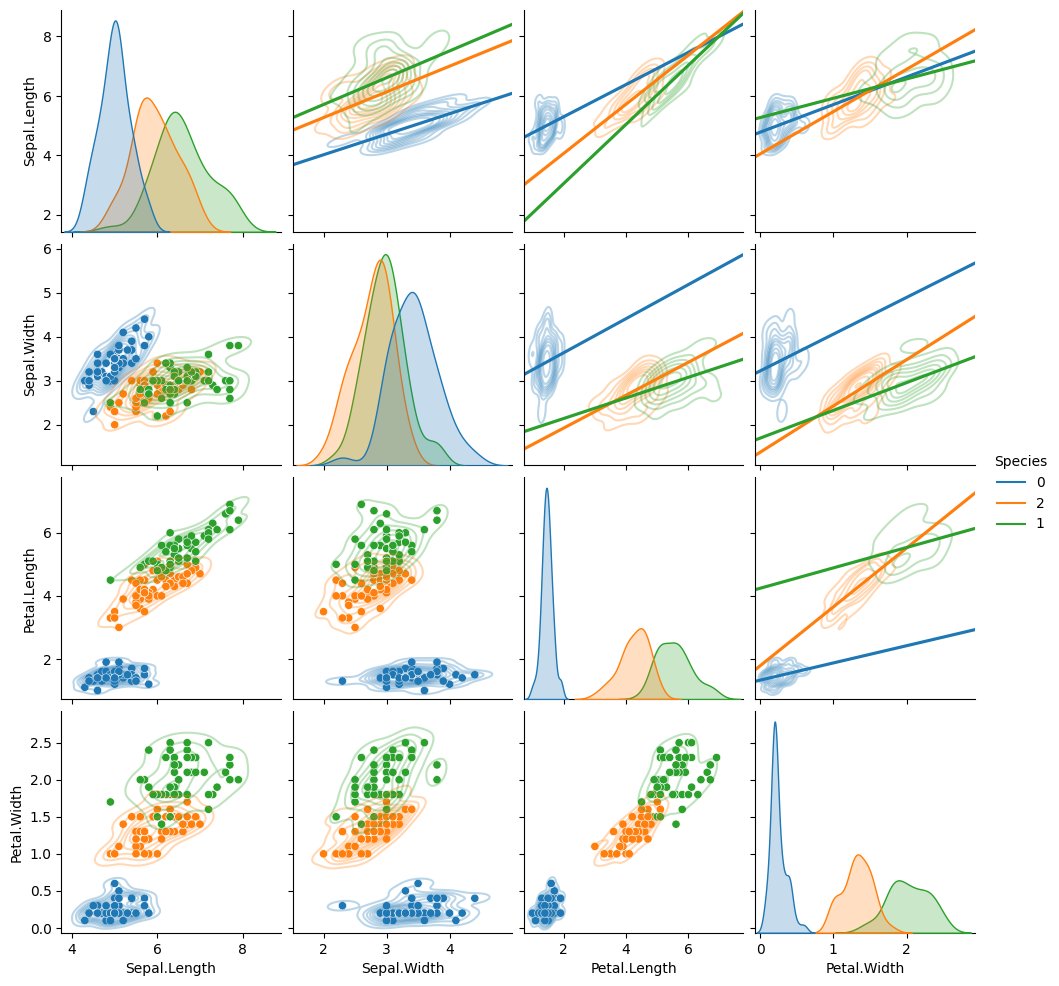

In [13]:
ax = sns.pairplot(origin,hue='Species',kind='kde',plot_kws={'alpha':0.3})
ax.map_lower(sns.scatterplot)
ax.map_upper(sns.regplot, scatter=False, truncate=False, ci=False)
plt.show()
plt.close()

## #05. 데이터 셋 분할하기
### 랜덤시드 고정

In [14]:
np.random.seed(777)


### 독립변수 - 종속변수 구분

In [15]:
x = origin.drop('Species',axis=1)
y = origin[['Species']]
x.shape,y.shape

((150, 4), (150, 1))

### 종속변수에 대한 one-hot-encoding
통상적인 더미변수 처리.

단 계산(회귀식)을 위한 처리가 아닌 분류를 위한 처리이므로 1번째 항목을 제외해서는 안된다.

In [16]:
y

,Species
0,0
1,0
2,0
3,0
4,0
...,...
145,1
146,1
147,1
148,1


In [19]:
y_cate = to_categorical(y)

In [20]:
y_cate

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

### 훈련데이터 & 검증데이터 분할


In [23]:
x_train,x_test,y_train,y_test = train_test_split(x,y_cate,test_size=0.3,random_state=31)
print("훈련용 데이터셋 크기: %s, 훈련용 레이블셋 크기: %s" % (x_train.shape, y_train.shape))
print("검증용 데이터셋 크기: %s, 검증용 레이블셋 크기: %s" % (x_test.shape, y_test.shape))


훈련용 데이터셋 크기: (105, 4), 훈련용 레이블셋 크기: (105, 3)
검증용 데이터셋 크기: (45, 4), 검증용 레이블셋 크기: (45, 3)


## #06. 모델 개발

In [25]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(4, )))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 515 (2.01 KB)
Trainable params: 515 (2.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [26]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500
4/4 [==============================] - 0s 46ms/step - loss: 1.8043 - acc: 0.3333 - val_loss: 1.5470 - val_acc: 0.4889 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 0s 8ms/step - loss: 1.5737 - acc: 0.4762 - val_loss: 1.3592 - val_acc: 0.6889 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 0s 8ms/step - loss: 1.3736 - acc: 0.6381 - val_loss: 1.2099 - val_acc: 0.6889 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 0s 8ms/step - loss: 1.2154 - acc: 0.6571 - val_loss: 1.1058 - val_acc: 0.6889 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 0s 13ms/step - loss: 1.1208 - acc: 0.4762 - val_loss: 1.0578 - val_acc: 0.2222 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 0s 11ms/step - loss: 1.0519 - acc: 0.2571 - val_loss: 1.0410 - val_acc: 0.3111 - lr: 0.0010
Epoch 7/500
4/4 [==============================] - 0s 8ms/step - loss: 1.0249 - acc: 0.3429 - val_loss: 1.0327 - val_acc: 0.3111 - lr: 0.0010
Epo

In [30]:
result_df = pd.DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs',inplace=True)
result_df

,loss,acc,val_loss,val_acc,lr
epochs,,,,,
1,1.804286,0.333333,1.546979,0.488889,0.00100
2,1.573652,0.476190,1.359158,0.688889,0.00100
3,1.373594,0.638095,1.209925,0.688889,0.00100
4,1.215352,0.657143,1.105779,0.688889,0.00100
5,1.120766,0.476190,1.057765,0.222222,0.00100
...,...,...,...,...,...
88,0.281065,0.980952,0.331381,0.955556,0.00050
89,0.280094,0.971429,0.334708,0.933333,0.00050
90,0.278399,0.971429,0.333909,0.933333,0.00050


c:\Users\Hamin\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Hamin\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Hamin\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Hamin\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option i

C:\Users\Hamin\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:93: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  func(*args, **kwargs)
C:\Users\Hamin\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:93: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  func(*args, **kwargs)
C:\Users\Hamin\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:93: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from current font.
  func(*args, **kwargs)
C:\Users\Hamin\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:93: UserWarning: Glyph 54984 (\N{HANGUL SYLLABLE HUN}) missing from current font.
  func(*args, **kwargs)
C:\Users\Hamin\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:93: UserWarning: Glyph 47144 (\N{HANGUL SYLLABLE RYEON}) missing from current font.
  func(*args, **kwargs)
C:\Users\Hamin\AppData\Roaming\Python\Python39\

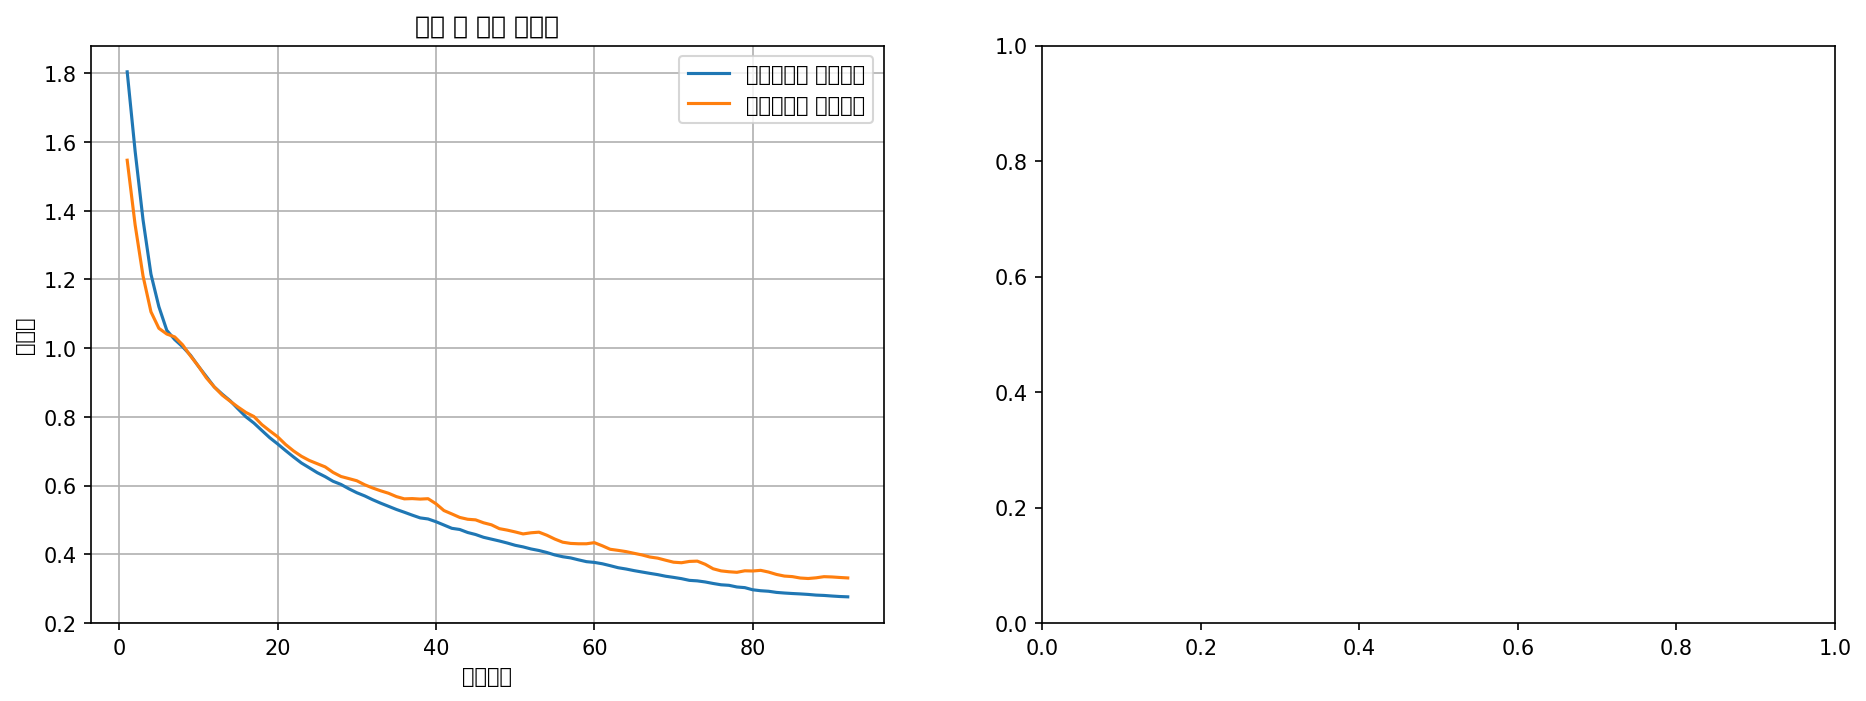

In [33]:
fig, ax = plt.subplots(1,2,figsize=(15,5),dpi = 150)

# 1) 훈련 및 검증데이터 손실함수 시각화
sns.lineplot(x=result_df.index, y='loss',data=result_df,label='훈련데이터 손실함수',ax=ax[0])
sns.lineplot(x=result_df.index,y='val_loss',data=result_df,label='검증데이터 손실함수',ax=ax[0])
ax[0].set_title('훈련 및 검증 손실률')
ax[0].set_xlabel('반복회차')
ax[0].set_ylabel('손실률')
ax[0].grid()
ax[0].legend()
# # 2) 훈련 및 검증 절대오차 그리기
# sns.lineplot(x=result_df.index , y='categorical_crossentropy',data=result_df,label='훈련데이터 acc',ax=ax[1])
# sns.lineplot(x=result_df.index, y='val_categorical_crossentropy',data=result_df,label='검증데이터 acc',ax=ax[1])
# ax[1].set_title('훈련 및 검증 절대오차')
# ax[1].set_xlabel('반복회차')
# ax[1].set_ylabel('정확도')
# ax[1].grid()
# ax[1].legend()

# plt.show()
# plt.close()



## #08.학습결과 적용
### 예측결과 산정

In [34]:
x_train.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
62,6.0,2.2,4.0,1.0
48,5.3,3.7,1.5,0.2
33,5.5,4.2,1.4,0.2
55,5.7,2.8,4.5,1.3
125,7.2,3.2,6.0,1.8


In [36]:
results=model.predict(x_test)
data_count, case_count = results.shape
print("%d개의 검증 데이터가 각각 %d개의 경우의 수를 갖는다." % (data_count, case_count))

print(results)

2/2 [==============================] - 0s 1ms/step
45개의 검증 데이터가 각각 3개의 경우의 수를 갖는다.
[[3.04851905e-02 4.64216501e-01 5.05298376e-01]
 [1.79233775e-03 8.71610522e-01 1.26597151e-01]
 [9.24135208e-01 3.45288846e-03 7.24118948e-02]
 [5.79094477e-02 3.15233916e-01 6.26856625e-01]
 [3.93759226e-03 7.74232209e-01 2.21830130e-01]
 [9.04689252e-01 4.96570533e-03 9.03450027e-02]
 [9.68709495e-03 6.68917179e-01 3.21395725e-01]
 [7.28197247e-02 2.61973500e-01 6.65206730e-01]
 [9.68990386e-01 7.51754560e-04 3.02578416e-02]
 [9.37899292e-01 2.44145631e-03 5.96593134e-02]
 [6.40583457e-03 6.61632299e-01 3.31961930e-01]
 [4.50260304e-02 3.63349468e-01 5.91624498e-01]
 [1.36051001e-02 6.22163951e-01 3.64230901e-01]
 [9.36893821e-01 2.92766187e-03 6.01785369e-02]
 [2.14004028e-03 7.56327212e-01 2.41532758e-01]
 [9.43657011e-03 6.52186394e-01 3.38377029e-01]
 [1.37311034e-02 5.71010530e-01 4.15258378e-01]
 [3.25284116e-02 4.32409883e-01 5.35061717e-01]
 [2.37925746e-03 8.92071068e-01 1.05549723e-01]
 [8.9

가장 큰 확률 값의 인덱스들만 별도의 리스트로 생성

In [37]:
arg_results= np.argmax(results,axis=1)
arg_results

array([2, 1, 0, 2, 1, 0, 1, 2, 0, 0, 1, 2, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1,
       0, 1, 2, 0, 2, 2, 2, 1, 0, 0, 2, 2, 2, 0, 2, 1, 1, 2, 0, 1, 1, 0,
       2], dtype=int64)

### 결과 데이터 셋 구성


In [39]:
result_df = pd.DataFrame({'실제값':np.argmax(y_test,axis=-1),
                          '분류결과' : arg_results
                          })

result_df

,실제값,분류결과
0,2,2
1,1,1
2,0,0
3,2,2
4,1,1
5,0,0
6,1,1
7,2,2
8,0,0
9,0,0


### 컬럼에 따른 값의 종류 형태로 데이터 재배치

In [40]:
mdf = result_df.melt()
mdf.reset_index(inplace=True)
mdf

,index,variable,value
0,0,실제값,2
1,1,실제값,1
2,2,실제값,0
3,3,실제값,2
4,4,실제값,1
...,...,...,...
85,85,분류결과,0
86,86,분류결과,1
87,87,분류결과,1
88,88,분류결과,0


In [42]:
df = pd.pivot_table(mdf, index='value', columns='variable', values='index', aggfunc='count')
df

variable,분류결과,실제값
value,,
0,13,13
1,17,14
2,15,18


In [43]:
cm = confusion_matrix(result_df['실제값'], result_df['분류결과'])
cmdf1 = pd.DataFrame(cm, index=[['실제값', '실제값', '실제값'], [0,1,2]], 
                  columns=[['분류결과', '분류결과', '분류결과'], [0,1,2]])
cmdf1

분류결과        
         0   1   2
실제값 0   13   0   0
    1    0  14   0
    2    0   3  15